In [2]:
import numpy
import scipy
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn
import matplotlib.pyplot as plt
import datetime
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
import json
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm

from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

df = pd.read_csv('/Users/sriramreddy/all.csv')
# all.csv')
date_columns = ['X32', 'X33']

def add_date_columns(column):
    df[column] = pd.to_datetime(df[column], format='%m/%d/%Y')
    df[column+'.year'] = df[column].dt.year
    df[column+'.month'] = df[column].dt.month
    df[column+'.dayofmonth'] = df[column].dt.day
    df[column+'.dayofweek'] = df[column].dt.dayofweek
    df[column+'.dayofyear'] = df[column].dt.dayofyear
    df[column+'.weekofyear'] = df[column].dt.weekofyear
    return df

for date in date_columns:
    df = add_date_columns(date)

df = df.drop(date_columns, axis = 1)


from sklearn.preprocessing import LabelEncoder

def encode(df):
    input=[]
    for col in df.columns:
        le = LabelEncoder()
        df_list = list(df[col].values.astype(str))
        le.fit(df_list)
        df[col] = le.transform(df_list)
        input.append(le)
    return df, input

# print("Before encoding df.head()")
# print(df.head())
df,input = encode(df)
# print("After encoding df.head()")
# print(df.head())

'''
def decode(df,input):
    for count,col in enumerate(df.columns):
#         print(count)
        le=input[count]
#         le.fit(df_list)
        df[col] = le.inverse_transform(df[col])
    return df

kf = decode(df,input)
print("After decoding df.head()")
print(kf.head())
'''
# Normalization

# df = (df - df.min())/(df.max()-df.min())

# Hoping that encoding will always in the same fashion
# There is some change in format (exactly in the exponential power nothing else)

'\ndef decode(df,input):\n    for count,col in enumerate(df.columns):\n#         print(count)\n        le=input[count]\n#         le.fit(df_list)\n        df[col] = le.inverse_transform(df[col])\n    return df\n\nkf = decode(df,input)\nprint("After decoding df.head()")\nprint(kf.head())\n'

In [3]:
# features = df.drop(['XID','Mailing Responded','Mailing Received'], axis=1)

In [4]:
# features.columns

In [5]:
def feature(df):
    df['add'] = df.drop(['XID','Mailing Responded','Mailing Received'], axis=1).sum(axis=1)
    df['square'] = (df['add'])*(df['add'])

    for i in ['add','square']:
        df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())
#     print(df.columns)
    return df

In [6]:
# features["add"] = features.sum(axis=1)
# features = (features - features.min())/(features.max()-features.min())
# target1 = df['Mailing Received']
# target2 = df['Mailing Received']

In [7]:
features = list(df.columns)
features.remove('XID')
features.remove('Mailing Received')
features.remove('Mailing Responded')

target = ['Mailing Received']

df_train , df_test = split(df,random_state=100, test_size=0.3)

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

def print_info(X, Y, probability):
    if probability is None:
        print("ROC curve, precision recall curve and average precision are not accurate")
        probability = Y
        
    false_positive_rate, true_positive_rate, threshold = roc_curve(X, probability)
    precision, recall, threshold = precision_recall_curve(X, probability)
    
    
    plt.plot(false_positive_rate, 
             true_positive_rate,
             color = 'darkorange', 
             lw=2, 
             label='ROC curve (area = %0.2f)' % auc(false_positive_rate, true_positive_rate))
    plt.plot([0,1],[0,1],'g--')
    plt.xlabel('False_positive_rate')
    plt.ylabel('True_positive_rate')

    # leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    # leg.get_frame().set_alpha(0.5)
    legend = plt.legend(fontsize='x-large')

    # Put a nicer background color on the legend.
    #legend.get_frame().set_facecolor('C0')
    plt.show()
    # https://en.wikipedia.org/wiki/Receiver_operating_characteristic
    #Area Under Curve as specified, I have imported from sklearn.
    plt.plot(recall, precision, color = 'darkorange', label="Precision Recall curve ")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    # leg = plt.legend(ncol=2, mode="expand", shadow=True, fancybox=True)
    # leg.get_frame().set_alpha(0.5) loc='upper center',
    legend = plt.legend(fontsize='x-large')
    # Put a nicer background color on the legend.
    #legend.get_frame().set_facecolor('C0')
    plt.show()
    tn,fp,fn,tp=confusion_matrix(X, Y).ravel()
    precision, recall, fscore, support = precision_recall_fscore_support(X, Y, average='binary')
    APS=average_precision_score(X, probability)
    AUC_FTPR=auc(false_positive_rate, true_positive_rate)
    print("(tn, fp, fn, tp) = ", confusion_matrix(X, Y).ravel())
    print("(precision, recall, fscore, support) = ", precision_recall_fscore_support(X, Y, average='binary'))
    print("Average precision score = ", average_precision_score(X, probability))
    print("Area Under Curve for fpr and tpr = ", auc(false_positive_rate, true_positive_rate))
    return [precision, recall, fscore, APS, AUC_FTPR]

def print_most_imp_features(z):
    a = z.coef_
    keys = list(a[0])
    values = features

    mydict = dict(zip(keys, values))

    keylist = list(mydict.keys())
    keylist.sort(reverse=True)
    
    imp = []
    for i in range(10):
        imp.append(mydict[keylist[i]])
    
    print("The Top 10 Important Features = ")
    print(imp)


In [8]:

#Costcla

def costcla_LR(fp, fn):
    n_samples = df.shape[0]
    cost_mat = numpy.zeros((n_samples, 4))
    cost_mat[:, 0] = fp
    cost_mat[:, 1] = fn
    cost_mat[:, 2] = 0
    cost_mat[:, 3] = 0

    sets = train_test_split(features, target, cost_mat, test_size=0.3, random_state=100)
    
    x_train, x_test, y_train, y_test, cost_mat_train, cost_mat_test = sets

    model = CostSensitiveLogisticRegression()
    z = model.fit(x_train, y_train, cost_mat_train)
    prediction = model.predict(x_test)
    
    X = y_test
    Y = prediction
#     (precision, recall, fscore, support) =
    #print_info(y_test, prediction, probability[:,1])
    print("(tn, fp, fn, tp) = ", confusion_matrix(X, Y).ravel())
    print("(precision, recall, fscore, support) = ", precision_recall_fscore_support(X, Y, average='binary'))
    print("Average precision score = ", average_precision_score(X, Y))

def costcla_Bayes(fp, fn, X, Y):
    n_samples = df.shape[0]
    cost_mat = numpy.zeros((n_samples, 4))
    cost_mat[:, 0] = fp
    cost_mat[:, 1] = fn
    cost_mat[:, 2] = 0
    cost_mat[:, 3] = 0
    
    sets = train_test_split(features, target, cost_mat, test_size=0.3, random_state=100)
    x_train, x_test, y_train, y_test, cost_mat_train, cost_mat_test = sets
    
    f = RandomForestClassifier(random_state=0).fit(x_train, y_train)
    y_prob_test = f.predict_proba(x_test)
    
    
    f_bmr = BayesMinimumRiskClassifier()
    f_bmr.fit(y_test, y_prob_test)
    prediction = f_bmr.predict(y_prob_test, cost_mat_test)
    

    X = y_test
    Y = prediction

    #print_info(y_test, prediction, probability[:,1])
    print("(tn, fp, fn, tp) = ", confusion_matrix(X, Y).ravel())
    print("(precision, recall, fscore, support) = ", precision_recall_fscore_support(X, Y, average='binary'))
    print("Average precision score = ", average_precision_score(X, Y))


l = [[2,5],[10,10],[3,10],[2,10],[10,2],[10,3],[5,8]]

for i in l:
    print(i)
    #costcla_Bayes(i[0], i[1], features, target)


#END OF costcla

[2, 5]
[10, 10]
[3, 10]
[2, 10]
[10, 2]
[10, 3]
[5, 8]


# Logistic Regression

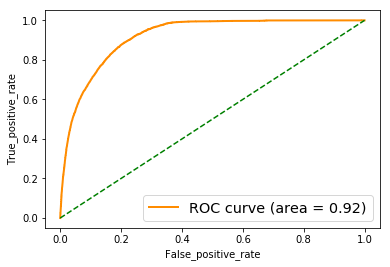

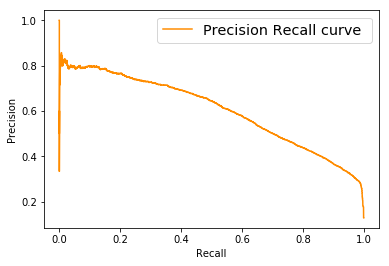

(tn, fp, fn, tp) =  [44946  1543  3680  3079]
(precision, recall, fscore, support) =  (0.6661618347035915, 0.4555407604675248, 0.5410772339864687, None)
Average precision score =  0.6041568938625459
Area Under Curve for fpr and tpr =  0.9179041063604682
The Top 10 Important Features = 
['X33.year', 'X37', 'X34', 'X8', 'X13', 'X14', 'X47', 'X35', 'X16', 'X45']


In [9]:
model = LogisticRegression()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

LR=print_info(y_test, prediction, probability[:,1])
print_most_imp_features(z)

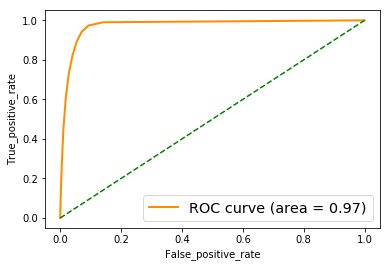

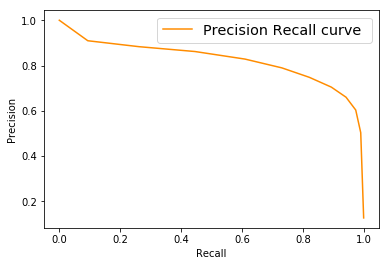

(tn, fp, fn, tp) =  [45172  1317  1816  4943]
(precision, recall, fscore, support) =  (0.7896166134185304, 0.7313212013611481, 0.7593517167217144, None)
Average precision score =  0.8030917607253887
Area Under Curve for fpr and tpr =  0.9732253763870682


In [10]:
model = RandomForestClassifier()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

RF=print_info(y_test, prediction, probability[:,1])
# print_most_imp_features(z)

ROC curve, precision recall curve and average precision are not accurate


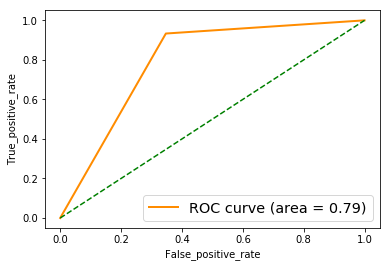

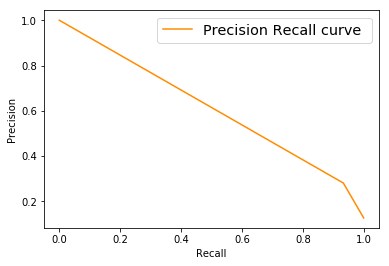

(tn, fp, fn, tp) =  [30349 16140   451  6308]
(precision, recall, fscore, support) =  (0.2810049893086244, 0.9332741529812102, 0.4319512445646592, None)
Average precision score =  0.27072449506319274
Area Under Curve for fpr and tpr =  0.7930476252225632
The Top 10 Important Features = 
['X37', 'X33.year', 'X34', 'X8', 'X13', 'X47', 'X20', 'X14', 'X24', 'X45']


In [11]:
model = svm.LinearSVC()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
#probability = model.predict_proba(x_test)



SVM=print_info(y_test, prediction, None)
print_most_imp_features(z)

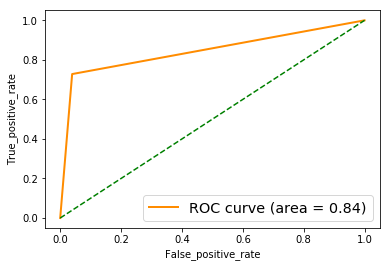

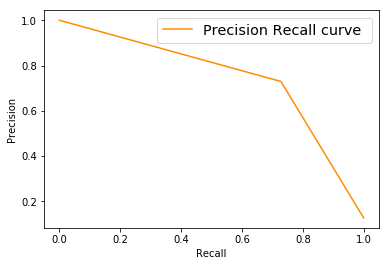

(tn, fp, fn, tp) =  [44664  1825  1837  4922]
(precision, recall, fscore, support) =  (0.7295094115903364, 0.7282142328746856, 0.7288612468532504, None)
Average precision score =  0.5657380848534278
Area Under Curve for fpr and tpr =  0.8444788172697979


In [12]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

DTC=print_info(y_test, prediction, probability[:,1])

In [13]:
# from sklearn.svm import SVC
# model = SVC(gamma='auto')
# # ,probability=True
# z = model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# probability = model.predict_proba(x_test)

# print_info(y_test, prediction, None)
# print_most_imp_features(z)


In [14]:
df.columns

Index(['XID', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
       'X31', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42',
       'X43', 'X44', 'X45', 'X46', 'X47', 'Mailing Received',
       'Mailing Responded', 'X32.year', 'X32.month', 'X32.dayofmonth',
       'X32.dayofweek', 'X32.dayofyear', 'X32.weekofyear', 'X33.year',
       'X33.month', 'X33.dayofmonth', 'X33.dayofweek', 'X33.dayofyear',
       'X33.weekofyear'],
      dtype='object')

In [15]:

def printline(l):
    for i in l:
        print(i,end=" ")
    print('')
print("Logistic_Regression",end=" ")
printline(LR)
print("Random_Forest_Classifier",end=" ")
printline(RF)
print("Linear_SVM",end=" ")
printline(SVM)
print("Decision_Tree_Classifier",end=" ")
printline(DTC)

Logistic_Regression 0.6661618347035915 0.4555407604675248 0.5410772339864687 0.6041568938625459 0.9179041063604682 
Random_Forest_Classifier 0.7896166134185304 0.7313212013611481 0.7593517167217144 0.8030917607253887 0.9732253763870682 
Linear_SVM 0.2810049893086244 0.9332741529812102 0.4319512445646592 0.27072449506319274 0.7930476252225632 
Decision_Tree_Classifier 0.7295094115903364 0.7282142328746856 0.7288612468532504 0.5657380848534278 0.8444788172697979 


# After feature addition

In [103]:
df=feature(df)
features = list(df.columns)
features.remove('XID')
features.remove('Mailing Received')
features.remove('Mailing Responded')

target = ['Mailing Received']

df_train , df_test = split(df,random_state=100, test_size=0.3)

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

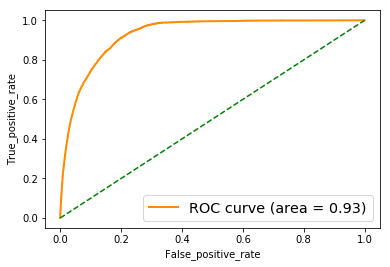

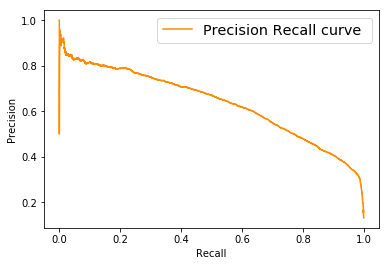

(tn, fp, fn, tp) =  [44882  1607  3435  3324]
(precision, recall, fscore, support) =  (0.6741026161022105, 0.4917887261429206, 0.5686911890504704, None)
Average precision score =  0.6372136293414926
Area Under Curve for fpr and tpr =  0.9288662485120138
The Top 10 Important Features = 
['X33.year', 'X42', 'X34', 'X31', 'X35', 'square', 'X30', 'X39', 'X8', 'X36']


In [104]:
model = LogisticRegression()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

LR=print_info(y_test, prediction, probability[:,1])
print_most_imp_features(z)

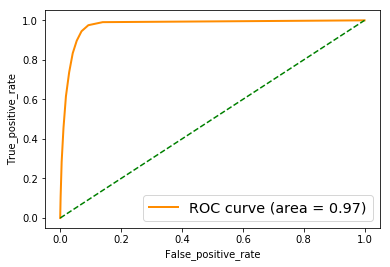

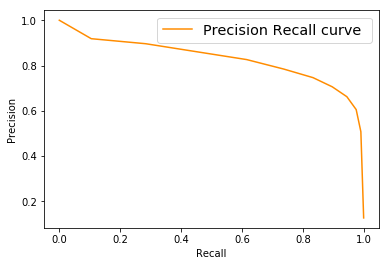

(tn, fp, fn, tp) =  [45120  1369  1776  4983]
(precision, recall, fscore, support) =  (0.7844773299748111, 0.7372392365734576, 0.760125085805812, None)
Average precision score =  0.8079546637496705
Area Under Curve for fpr and tpr =  0.9738377913190912


In [105]:
model = RandomForestClassifier()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

RF=print_info(y_test, prediction, probability[:,1])
# print_most_imp_features(z)

ROC curve, precision recall curve and average precision are not accurate


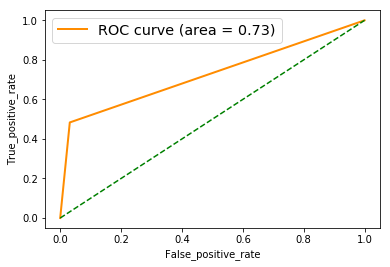

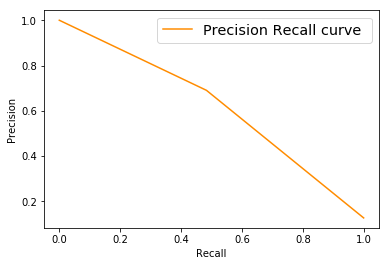

(tn, fp, fn, tp) =  [45024  1465  3491  3268]
(precision, recall, fscore, support) =  (0.6904711599408409, 0.48350347684568723, 0.5687434737208493, None)
Average precision score =  0.3994063543296096
Area Under Curve for fpr and tpr =  0.7259953229267048
The Top 10 Important Features = 
['square', 'X33.year', 'X42', 'X34', 'X35', 'X31', 'X6', 'X30', 'X36', 'X39']
Average precision score is wrong


In [106]:
model = svm.LinearSVC()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
#probability = model.predict_proba(x_test)

SVM=print_info(y_test, prediction, None)
print_most_imp_features(z)
print("Average precision score is wrong")

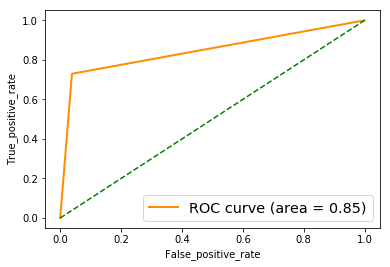

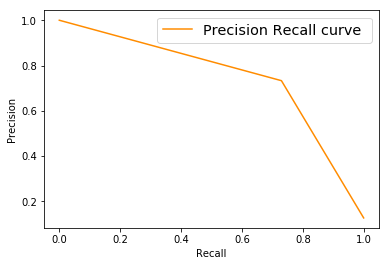

(tn, fp, fn, tp) =  [44693  1796  1826  4933]
(precision, recall, fscore, support) =  (0.7330955565462922, 0.7298416925580707, 0.7314650059311981, None)
Average precision score =  0.5693360695850084
Area Under Curve for fpr and tpr =  0.8456044488516871


In [107]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

DTC=print_info(y_test, prediction, probability[:,1])

In [108]:
print("After Feature Addition")
print("Logistic_Regression",end=" ")
printline(LR)
print("Random_Forest_Classifier",end=" ")
printline(RF)
print("Linear_SVM",end=" ")
printline(SVM)
print("Decision_Tree_Classifier",end=" ")
printline(DTC)

After Feature Addition
Logistic_Regression 0.6741026161022105 0.4917887261429206 0.5686911890504704 0.6372136293414926 0.9288662485120138 
Random_Forest_Classifier 0.7844773299748111 0.7372392365734576 0.760125085805812 0.8079546637496705 0.9738377913190912 
Linear_SVM 0.6904711599408409 0.48350347684568723 0.5687434737208493 0.3994063543296096 0.7259953229267048 
Decision_Tree_Classifier 0.7330955565462922 0.7298416925580707 0.7314650059311981 0.5693360695850084 0.8456044488516871 


In [109]:
df.columns

Index(['XID', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
       'X31', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42',
       'X43', 'X44', 'X45', 'X46', 'X47', 'Mailing Received',
       'Mailing Responded', 'X32.year', 'X32.month', 'X32.dayofmonth',
       'X32.dayofweek', 'X32.dayofyear', 'X32.weekofyear', 'X33.year',
       'X33.month', 'X33.dayofmonth', 'X33.dayofweek', 'X33.dayofyear',
       'X33.weekofyear', 'add', 'square'],
      dtype='object')

In [138]:
# features

In [111]:
target

['Mailing Received']

# Over Sampling SMOTE analysis

In [140]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X = df[features]
y = df[target]
# df_train , df_test = split(df,random_state=100, test_size=0.3)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

a=y_train['Mailing Received'].value_counts()[1]
b=y_train['Mailing Received'].value_counts()[0]
c=y_test['Mailing Received'].value_counts()[1]
d=y_test['Mailing Received'].value_counts()[0]

print("Train, counts of label '1':",a)
print("Train, counts of label '0':", b)
print("percentage of 1's in total", (a*100)/(a+b))

print("Test, counts of label '1':", c)
print("Test, counts of label '0': ", d)
print("percentage of 1's in total", (c*100)/(c+d))

print("After SMOTE")
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_sample(X_train, y_train)
a=y_train[y_train==1].sum()
b=y_train.shape[0]-a
print("Train, counts of label '1':",a)
print("Train, counts of label '0':", b)
print("percentage of 1's in total", (a*100)/(a+b))


Train, counts of label '1': 16072
Train, counts of label '0': 108171
percentage of 1's in total 12.93594005296073
Test, counts of label '1': 6775
Test, counts of label '0':  46473
percentage of 1's in total 12.723482572115385


Train, counts of label '1': 108171.0
Train, counts of label '0': 108171.0
percentage of 1's in total 50.0


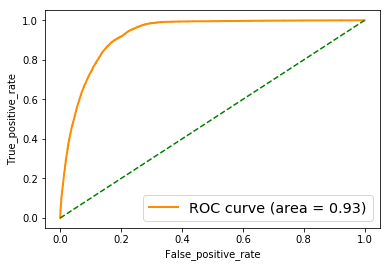

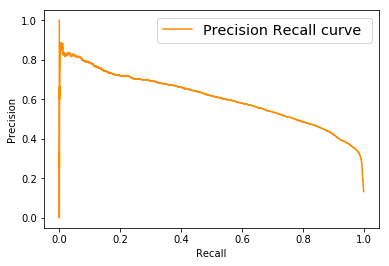

(tn, fp, fn, tp) =  [38924  7549   821  5954]
(precision, recall, fscore, support) =  (0.4409390505813523, 0.8788191881918819, 0.5872374001380807, None)
Average precision score =  0.6076609775757063
Area Under Curve for fpr and tpr =  0.9274361266626029
The Top 10 Important Features = 
['square', 'X33.year', 'X42', 'X31', 'X34', 'X39', 'X35', 'X8', 'X5', 'X25']


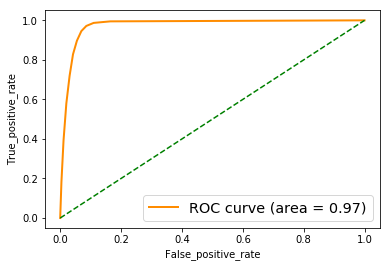

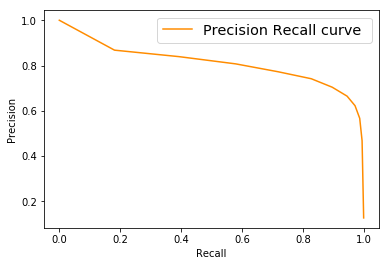

(tn, fp, fn, tp) =  [44520  1953  1166  5609]
(precision, recall, fscore, support) =  (0.7417349907431896, 0.8278966789667896, 0.7824510009067448, None)
Average precision score =  0.7843941793630796
Area Under Curve for fpr and tpr =  0.9736373879909478
ROC curve, precision recall curve and average precision are not accurate


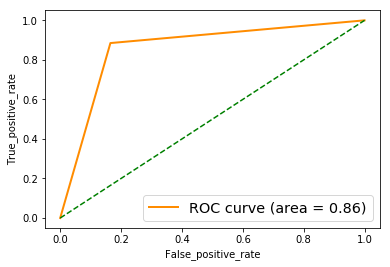

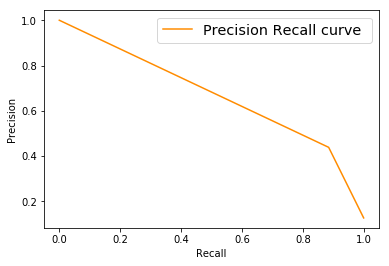

(tn, fp, fn, tp) =  [38807  7666   779  5996]
(precision, recall, fscore, support) =  (0.4388815693163519, 0.8850184501845019, 0.5867788814405245, None)
Average precision score =  0.4030479437428229
Area Under Curve for fpr and tpr =  0.8600312271149309
The Top 10 Important Features = 
['square', 'X33.year', 'X42', 'X31', 'X34', 'X35', 'X39', 'X8', 'X5', 'X25']
Average precision score is wrong


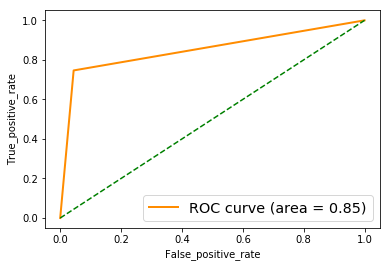

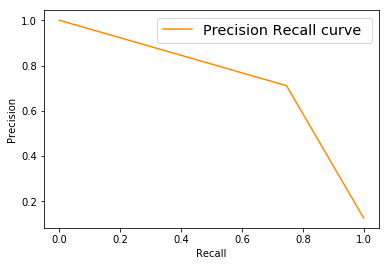

(tn, fp, fn, tp) =  [44419  2054  1717  5058]
(precision, recall, fscore, support) =  (0.7111923509561305, 0.7465682656826568, 0.7284510693454309, None)
Average precision score =  0.5631989825681667
Area Under Curve for fpr and tpr =  0.8511852797438308
After Feature Addition
Logistic_Regression 0.4409390505813523 0.8788191881918819 0.5872374001380807 0.6076609775757063 0.9274361266626029 
Random_Forest_Classifier 0.7417349907431896 0.8278966789667896 0.7824510009067448 0.7843941793630796 0.9736373879909478 
Linear_SVM 0.4388815693163519 0.8850184501845019 0.5867788814405245 0.4030479437428229 0.8600312271149309 
Decision_Tree_Classifier 0.7111923509561305 0.7465682656826568 0.7284510693454309 0.5631989825681667 0.8511852797438308 


In [142]:
model = LogisticRegression()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

LR=print_info(y_test, prediction, probability[:,1])
print_most_imp_features(z)



model = RandomForestClassifier()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

RF=print_info(y_test, prediction, probability[:,1])

model = svm.LinearSVC()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
#probability = model.predict_proba(x_test)

SVM=print_info(y_test, prediction, None)
print_most_imp_features(z)
print("Average precision score is wrong")


from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

DTC=print_info(y_test, prediction, probability[:,1])


print("After Feature Addition")
print("Logistic_Regression",end=" ")
printline(LR)
print("Random_Forest_Classifier",end=" ")
printline(RF)
print("Linear_SVM",end=" ")
printline(SVM)
print("Decision_Tree_Classifier",end=" ")
printline(DTC)

# Hyper parameter Tuning of C in Logistic Regression

In [144]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }

lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.8596256066558817, total=   6.6s
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.8667606545252843, total=   7.0s
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.8667606545252843, total=   8.0s
[CV] C=2.0 ...........................................................
[CV] .................. C=1.0, score=0.8646574835906443, total=   7.1s
[CV] C=2.0 ...........................................................
[CV] .................. C=1.0, score=0.8690256078395119, total=   6.6s
[CV] C=2.0 ...........................................................
[CV] ...........

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   34.6s


[CV] .................. C=3.0, score=0.8646805953591569, total=   7.6s
[CV] C=4.0 ...........................................................
[CV] .................. C=3.0, score=0.8666450956827216, total=   9.9s
[CV] C=4.0 ...........................................................
[CV] .................. C=3.0, score=0.8688176019228991, total=  10.0s
[CV] C=4.0 ...........................................................
[CV] .................. C=4.0, score=0.8601571527617287, total=   9.3s
[CV] C=4.0 ...........................................................
[CV] ................... C=4.0, score=0.867014883978922, total=  10.0s
[CV] C=4.0 ...........................................................
[CV] .................. C=4.0, score=0.8666219839142091, total=   9.2s
[CV] C=5.0 ...........................................................
[CV] .................. C=4.0, score=0.8645881482851068, total=   9.9s
[CV] C=5.0 ...........................................................
[CV] .

[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [145]:
clf.best_params_

{'C': 9.0}

[LibLinear]

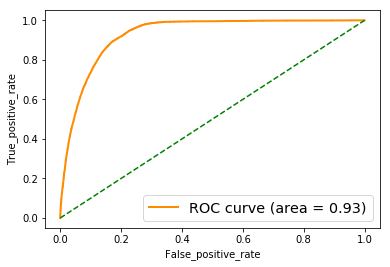

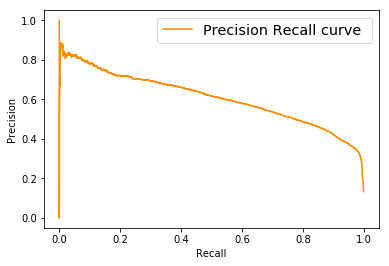

(tn, fp, fn, tp) =  [38941  7532   820  5955]
(precision, recall, fscore, support) =  (0.4415362942092385, 0.8789667896678967, 0.5877998223275096, None)
Average precision score =  0.6074097446183166
Area Under Curve for fpr and tpr =  0.9274077198973525
The Top 10 Important Features = 
['square', 'X33.year', 'X42', 'X31', 'X34', 'X39', 'X35', 'X8', 'X5', 'X6']


In [146]:
model=LogisticRegression(C=9,penalty='l1', verbose=5)
z = model.fit(x_train, y_train)
prediction = model.predict(x_test)
probability = model.predict_proba(x_test)

LR=print_info(y_test, prediction, probability[:,1])
print_most_imp_features(z)

In [147]:
print("Logistic_Regression",end=" ")
printline(LR)

Logistic_Regression 0.4415362942092385 0.8789667896678967 0.5877998223275096 0.6074097446183166 0.9274077198973525 


In [157]:
prediction.shape

(53248,)

In [153]:
features = list(df.columns)
features.remove('XID')
features.remove('Mailing Responded')
target = ['Mailing Responded']
features.append(['output'])


# One class SVC


# 49 th predicted



In [17]:
# model = RandomForestClassifier()
# model.get_params()
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# clf = GridSearchCV(estimator = model, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# clf.fit(x_train, y_train)

# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# z = model.fit(x_train, y_train)
# prediction = model.predict(x_test)
# probability = model.predict_proba(x_test)

# RF=print_info(y_test, prediction, probability[:,1])